In [1]:
import torch 
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
import numpy as np
import os
import torch.nn as nn
from torch.utils.data import random_split

In [3]:
trans_compose=transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])
datadir="classes"
dataset=ImageFolder(datadir,transform=trans_compose)


In [4]:
dataset
len(dataset)

6202

In [5]:
image,lab=dataset[0]

In [6]:
image.shape

torch.Size([3, 32, 32])

In [7]:
# image.reshape(-1,1024).shape

In [8]:
# demo_model=nn.Linear(32*32,2)

In [9]:
# outputs=demo_model(image.reshape(-1,1024))

In [10]:
# list(demo_model.parameters())

In [11]:
# probs=F.softmax(outputs,dim=1)
# max_probs,preds=torch.max(probs,dim=1)

In [12]:
# (torch.sum(preds==lab)/len(preds)).item()

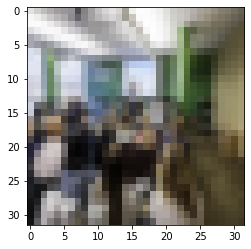

In [13]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))

In [14]:
train_ds,val_ds=random_split(dataset,[4962,1240])

In [15]:
train_dl=DataLoader(train_ds,batch_size=128,num_workers=4,shuffle=True,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size=128*2,num_workers=4,pin_memory=True)

In [16]:
val_dl

In [17]:
train_dl

In [18]:
def apply_kernel(image,kernel):
    ri,ci=image.shape
    rk,ck=kernel.shape
    ro,co=ri-rk+1,ci-ck+1
    output=torch.zeros([ro,co])
    
    for i in range(ro):
        for j in range(co):
            output[i,j]=torch.sum(image[i:i+rk,j:j+ck]*kernel)
            
    return output

In [19]:
class ClassificationBase(nn.Module):
    def training_step(self,batch):
        img,labels=batch
        out=self(img)
        loss=F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        img,labels=batch
        out=self(img)
        loss=F.cross_entropy(out,labels)
        acc=accuracy(out,labels)
        return {'val_loss':loss.detach(), 'val_acc':acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses=[x['val_loss'] for x in outputs]
        epoch_loss=torch.stack(batch_losses).mean()
        batch_acc=[x['val_acc'] for x in outputs]
        epoch_acc=torch.stack(batch_acc).mean()
        return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}
    
    def epoch_end(self,epoch,result):
        print("Epoch [{}], val_loss:{:.4f}, val_acc:{:.4f} ".format(epoch,result['val_loss'],result['val_acc']))
     

def accuracy(outputs, labels):
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item())/len(preds)

In [20]:
class CNN(ClassificationBase):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(nn.Conv2d(3,32,kernel_size=3,padding=1),
                                  nn.ReLU(),
                                  nn.Conv2d(32,64,kernel_size=3,padding=1,stride=1),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2,2),

                                  nn.Conv2d(64,128,kernel_size=3,padding=1,stride=1),
                                  nn.ReLU(),
                                  nn.Conv2d(128,128,kernel_size=3,padding=1,stride=1),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2,2),

                                  nn.Conv2d(128,256,kernel_size=3,padding=1,stride=1),
                                  nn.ReLU(),
                                  nn.Conv2d(256,256,kernel_size=3,padding=1,stride=1),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2,2),
                                   
                                   nn.Flatten(),
                                   nn.Linear(256*4*4,1024),
                                   nn.ReLU(),
                                   nn.Linear(1024,512),
                                   nn.ReLU(),
                                   nn.Linear(512,2)
                                  )
    def forward(self,xb):
        return self.network(xb)
    

In [21]:
model=CNN()

In [22]:
@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()
    outputs=[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
    
def fit(epochs,lr,model,train_loader,val_loader,opt_func=torch.optim.SGD):
    history=[]
    optimizer=opt_func(model.parameters(),lr)
    
    for epoch in range(epochs):
        #train phase
        model.train()
        train_losses=[]
        for batch in train_loader:
            loss=model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #validation phase
        
        result=evaluate(model,val_loader)
        result['train_loss']=torch.stack(train_losses).mean().item()
        model.epoch_end(epoch,result)
        history.append(result)
        
    return history

In [23]:
evaluate(model,val_dl)

{'val_loss': 0.6925455331802368, 'val_acc': 0.5315682888031006}

In [24]:
history=fit(5,0.001,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], val_loss:0.6686, val_acc:0.5316 
Epoch [1], val_loss:0.6472, val_acc:0.6341 
Epoch [2], val_loss:0.6097, val_acc:0.7185 
Epoch [3], val_loss:0.5813, val_acc:0.6838 
Epoch [4], val_loss:0.5395, val_acc:0.7348 


In [25]:
FILE="model.pth"
torch.save(model.state_dict(),'model.pth')
# torch.save(model,FILE)
# import pickle
# pickle.dump(model,open("torch_model.pkl","wb"))

In [26]:
from PIL import Image
composer=transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])
testing=[]
for i in os.listdir("imgs"):
    img=Image.open(os.path.join("imgs",i))
    testing.append(composer(img))


In [27]:
pred=[]
for j in testing:
    xb=j.unsqueeze(0)
    yb=model(xb)
    _, preds  = torch.max(yb, dim=1)
    pred.append(preds[0].item())

In [28]:
pred

[0, 1]